Best alpha: 0.01
Mean Squared Error on validation set: 12.334799455892023
Mean Squared Error on test set: 14.107486478734836


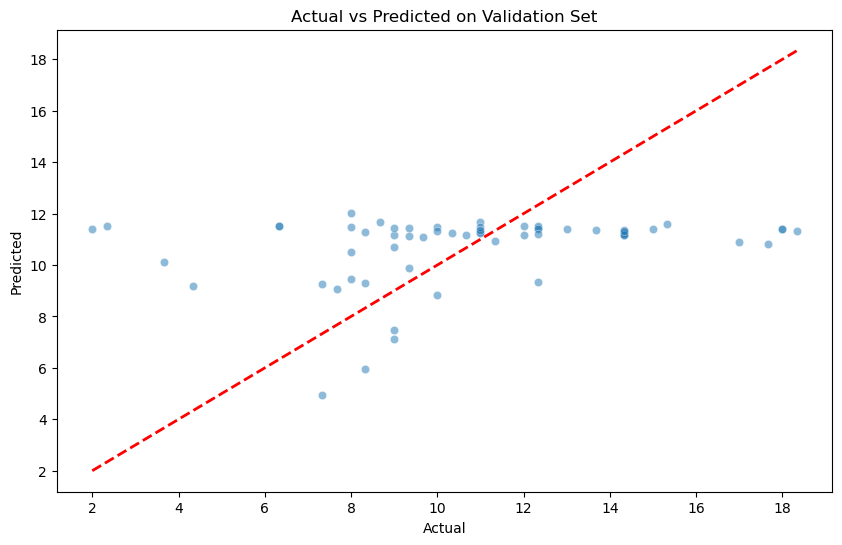

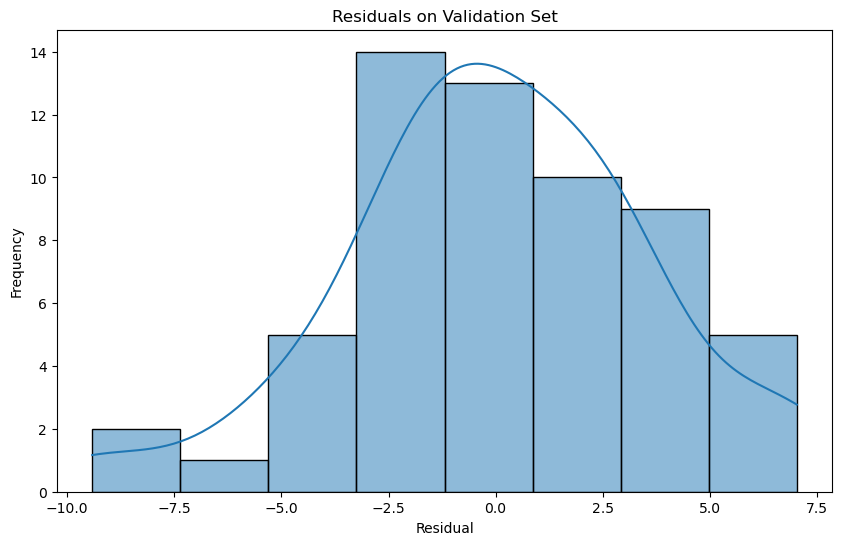

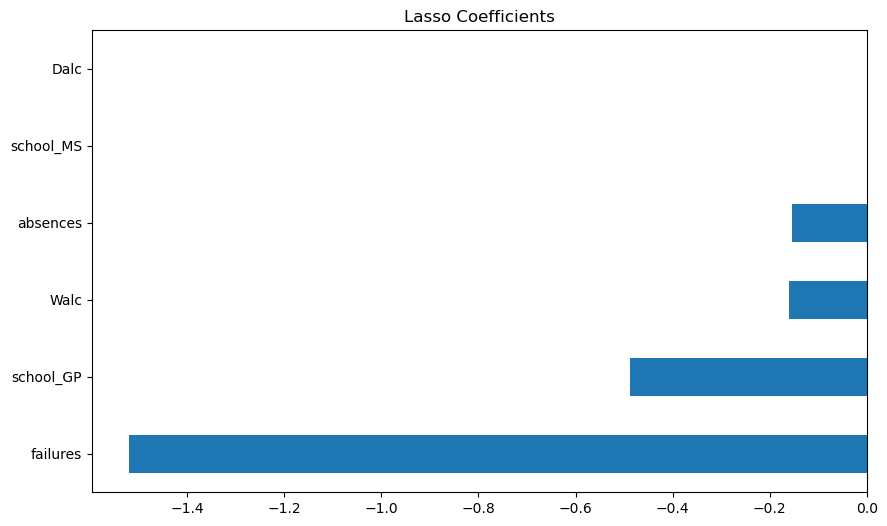

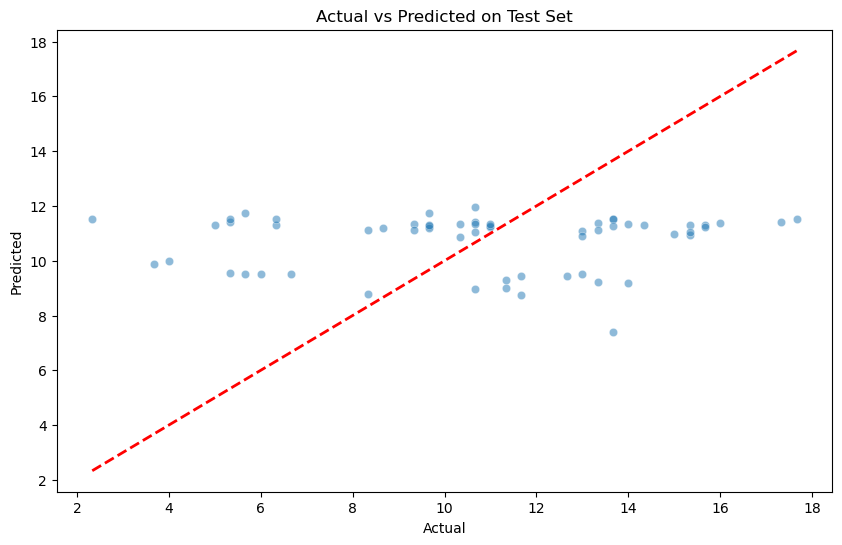

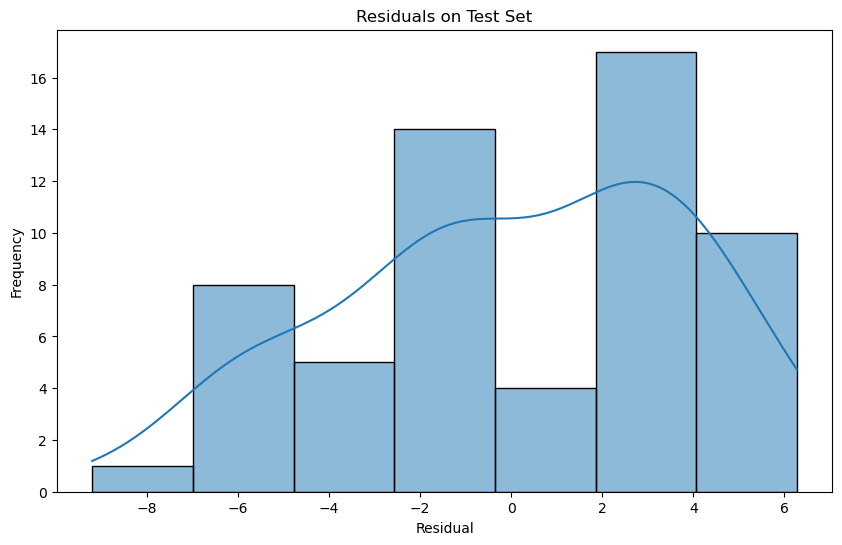

In [12]:
import pandas as pd
import numpy as np
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
import matplotlib.pyplot as plt
import seaborn as sns

# Load the data
train_csv = pd.read_csv("train_data.csv")
validation_csv = pd.read_csv("validation_data.csv")
test_csv = pd.read_csv("test_data.csv")


# Preprocessing
# One-hot encoding
encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)
school_encoded = encoder.fit_transform(train_csv[['school']])
school_encoded_val = encoder.transform(validation_csv[['school']])
school_encoded_test = encoder.transform(test_csv[['school']])

# Standardize features (excluding 'school' and 'Avg Grade of 3 Period')
features_to_scale = train_csv.columns.drop(['school', 'Avg Grade of 3 Period'])

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(train_csv[features_to_scale])
X_validation_scaled = scaler.transform(validation_csv[features_to_scale])
X_test_scaled = scaler.transform(test_csv[features_to_scale])

# Concatenate encoded school back to features
X_train = np.concatenate([school_encoded, X_train_scaled], axis=1)
X_validation = np.concatenate([school_encoded_val, X_validation_scaled], axis=1)
X_test = np.concatenate([school_encoded_test, X_test_scaled], axis=1)

# Define Lasso Regression Model with grid search for hyperparameter tuning
parameters = {'alpha': [0.001, 0.01, 0.1, 1, 10, 100]}
lasso = Lasso()
clf = GridSearchCV(lasso, parameters, scoring='neg_mean_squared_error')

# Fit the model on training data
clf.fit(X_train, y_train)

# Best hyperparameter
print(f"Best alpha: {clf.best_params_['alpha']}")

# Evaluate the model on validation data
y_val_pred = clf.predict(X_validation)
mse_val = mean_squared_error(y_validation, y_val_pred)
print(f'Mean Squared Error on validation set: {mse_val}')

# Predict and evaluate on test data
y_test_pred = clf.predict(X_test)
mse_test = mean_squared_error(y_test, y_test_pred)
print(f'Mean Squared Error on test set: {mse_test}')


# Actual vs Predicted Plot
def plot_actual_vs_predicted(y_actual, y_predicted, title):
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x=y_actual, y=y_predicted, alpha=0.5)
    plt.plot([y_actual.min(), y_actual.max()], [y_actual.min(), y_actual.max()], 'r--', lw=2)
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    plt.title(title)
    plt.show()

# Residual Plot
def plot_residuals(y_actual, y_predicted, title):
    residuals = y_actual - y_predicted
    plt.figure(figsize=(10, 6))
    sns.histplot(residuals, kde=True)
    plt.title(title)
    plt.xlabel('Residual')
    plt.ylabel('Frequency')
    plt.show()

# Coefficient Plot
def plot_coefficients(model, feature_names, title):
    coef = model.best_estimator_.coef_
    importance = pd.Series(data=coef, index=feature_names)
    importance_sorted = importance.sort_values()
    plt.figure(figsize=(10, 6))
    importance_sorted.plot(kind='barh')
    plt.title(title)
    plt.show()

# Feature names after one-hot encoding and standardization
feature_names = list(encoder.get_feature_names_out(['school'])) + list(train_csv.drop(['school', 'Avg Grade of 3 Period'], axis=1).columns)

# Plotting
plot_actual_vs_predicted(y_validation, y_val_pred, 'Actual vs Predicted on Validation Set')
plot_residuals(y_validation, y_val_pred, 'Residuals on Validation Set')
plot_coefficients(clf, feature_names, 'Lasso Coefficients')

# Similarly, plot for the test set
plot_actual_vs_predicted(y_test, y_test_pred, 'Actual vs Predicted on Test Set')
plot_residuals(y_test, y_test_pred, 'Residuals on Test Set')
